## Best model - 2 models color / grayscale with occlusion weighted MSE loss function
(The result varies from 0.00089 to 0.0025 for 30 epochs training)

In [1]:
# Import required libraries to run the naive baseline
import pandas as pd
import numpy as np
from PIL import Image
import cv2
from tqdm import tqdm
from collections import OrderedDict
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v3_small

# from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torch.optim as optim

c:\Users\ASUS\envs\virtual\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#############################################
# FUNCTIONS
#############################################

# PREPROCESSING
# --------------------------------------------

# function to check if image is black and white

def is_color(img):
    # check if image has 3 channels
    dim = len(np.array(img).shape)
    
    if dim == 2: # with 1 channel dimension = (224,224) => greyscale image
        return 0
    # if image has 3 channels and all channels are equal
    elif dim == 3: # for example (224, 224, 3)
        if ((np.array(img)[:,:,2] == np.array(img)[:,:,1]).all() == True &
            (np.array(img)[:,:,0] == np.array(img)[:,:,1]).all() == True &
            (np.array(img)[:,:,0] == np.array(img)[:,:,2]).all() == True ):
            return 0
        else:
            return 1
    else:
        return 0

def preprocess_df(df, image_dir, process_mediapipe=False):
    # add gender and FaceOcclusion columns with -1 values (for test)
    if 'gender' not in df.columns:
        df['gender'] = - np.ones(len(df)).astype(float)
    if 'FaceOcclusion' not in df.columns:
        df['FaceOcclusion'] = -np.ones(len(df)).astype(float)
        
    # preprocess the dataframe
    df['initial_index'] = df.index
    df = df.dropna(subset=['FaceOcclusion'])
    df['gender_id'] = np.round(df['gender'] ).astype(int)
    df['db_number'] = df['filename'].apply(lambda x: (x.split('/')[0])[-1])
    df['db_number'] = df['db_number'].astype(int)
    df['count']=1

    # add columns for the image properties
    df['color']= 0 # 1 = color 0 = black & white (grayscale)
    df['image_width'] = np.zeros(len(df)).astype(int)
    df['image_height'] = np.zeros(len(df)).astype(int)
    df['channels'] = np.zeros(len(df)).astype(int)
    df['pixels'] = np.zeros(len(df)).astype(int)

    if process_mediapipe == True:
        df['face'] = np.ones(len(df)).astype(int)   # 1 = 1 face detected, 0 = no face detected
        df['face_pixels'] = np.zeros(len(df)).astype(int)
        df['mask_pixels'] = np.zeros(len(df)).astype(int)
        print('use preprocessing _mediapipe file to get mediapipe mask, mesh and contours')

    # loop through the images to extract properties
    for i in df.index:

        if i % 5000 == 0: print(i)

        try:
            filename = df.loc[i, 'filename']
    
            # load image; convert and save information
            image = cv2.imread(f"{image_dir}/{filename}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            df.loc[i, 'image_width'] = image.shape[0]
            df.loc[i, 'image_height'] = image.shape[1]
            df.loc[i, 'pixels'] = image.shape[0] * image.shape[1]
            df.loc[i, 'channels'] = image.shape[2]

            if is_color(image)==1:
                df.loc[i, 'color'] = 1

            if process_mediapipe == True:
                # to be added
                print('use preprocessing _mediapipe file to get mediapipe mask, mesh and contours')

        except ValueError as e:
            print(f'could not open {filename} (index {i}): {e}')

    df['no_color']= 1 - df['color']

    return df

def process_mediapipe(df, image_dir, save_to_file=False):
    '''function to apply mediapipe face mesh model to images, get masked images, 
    contours and mesh, and return 468 landmarks (3D keypoints)
    Input :
        df : panda dataframe with image filenames
        image_dir : directory where images are stored
    Output :
        df : panda dataframe with additional columns for number of faces detected, face pixels, mask pixels,
        masked_image: image with skin area, ans black mask overlay (ovale) elsewhere 
        contours : image with face ovale contours, brows and lips in green
        mesh : image with face mesh keypoints
        landmarks : 468 landmarks (3D keypoints) in mediapipe format (madiapipe array of (x, y, z) coordinates in dictionary format)
    '''
#---------------------------------------
# SHOW IMAGES
#---------------------------------------

def show_images(df, image_dir, n_images=5, title='None'):
    N = len(df)
    plt.figure(figsize=(15, (N//5 + 1)*3))
    for i in range(N):
        plt.subplot(N//5 + 1, n_images, i + 1)
        img = Image.open(f"{image_dir}/{df.iloc[i]['filename']}")
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

#---------------------------------------
# DEFINE DEVICE
#---------------------------------------
def get_device():
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available():
        device = "mps"
    else:
        device = "cpu"
    return device

#---------------------------------------
# DEFINE DATASET CLASS
#---------------------------------------

#class Dataset(torch.utils.data.Dataset): # in "starter notebook code" dataset is imported from torch.utils.data
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
         'Initialization'
         self.image_dir = image_dir
         self.df = df
         self.transform = transforms.ToTensor()
         
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.df.loc[index]
        filename = row['filename']
        

        # Load data and get label
        img = Image.open(f"{self.image_dir}/{filename}")  
        X = self.transform(img)

        y = row['FaceOcclusion']     
        y = np.float32(y)

        gender = row['gender_id'] # changed to have round values 0 or 1

        return X, y, gender, filename

#--------------------------------------------------
# Compute mean and standard deviation on the pixels
#--------------------------------------------------

def calculate_mean_std(loader, num_channels=3):
    '''Calculate mean and standard deviation of the dataset.
    Args:
        loader: DataLoader object
        num_channels: number of channels
    Returns:
        mean: mean of the dataset (tensor)
        std: standard deviation of the dataset (tensor)
    '''
    device = get_device()
    channel_sum = torch.zeros(num_channels).to(device)
    channel_squared_sum = torch.zeros(num_channels).to(device)
    num_elements = 0

    for data, _, _, _ in loader:
        data = data.to(device)
        channel_sum += data.sum(dim=[0, 2, 3])
        channel_squared_sum += (data ** 2).sum(dim=[0, 2, 3])
        num_elements += data.size(0) * data.size(2) * data.size(3)

    mean = channel_sum / num_elements
    std = (channel_squared_sum / num_elements - mean ** 2) ** 0.5
    return mean, std

In [3]:
df_train = pd.read_csv("listes_training/data_100K/train_100K.csv", delimiter=' ')
df_test = pd.read_csv("listes_training/data_100K/test_students.csv", delimiter=' ')

image_dir = "crops_100K"

df_train = df_train.dropna()
df_test = df_test.dropna()
df_train.head(-10)

,filename,FaceOcclusion,gender
0,database1/img00011271.jpg,0.019,0.999
1,database1/img00012471.jpg,0.035,1.000
2,database1/img00008127.jpg,0.127,0.001
3,database1/img00008972.jpg,0.014,0.999
4,database1/img00028187.jpg,0.346,0.982
...,...,...,...
101330,database3/database3/m.01drbr/59-FaceId-0_align...,0.000,1.000
101331,database3/database3/m.01drbr/69-FaceId-0_align...,0.021,0.998
101332,database3/database3/m.01drbr/7-FaceId-0_align.jpg,0.008,1.000
101333,database3/database3/m.01drbr/71-FaceId-0_align...,0.005,1.000


In [4]:
df_test.head(-10)

,filename
0,database2/database2/test/0.jpg
1,database2/database2/test/1.jpg
2,database2/database2/test/2.jpg
3,database2/database2/test/3.jpg
4,database2/database2/test/4.jpg
...,...
30492,database3/database3/m.01507p/75-FaceId-0_align...
30493,database3/database3/m.01507p/76-FaceId-0_align...
30494,database3/database3/m.01507p/77-FaceId-0_align...
30495,database3/database3/m.01507p/78-FaceId-0_align...


# 1 Data exploration

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101341 entries, 0 to 101344
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   filename       101341 non-null  object 
 1   FaceOcclusion  101341 non-null  float64
 2   gender         101341 non-null  float64
dtypes: float64(2), object(1)
memory usage: 3.1+ MB


In [6]:

preprocess = False

if preprocess== True:

    # Preprocess the train data
    print('Preprocessing train dataset')
    df_train = preprocess_df(df_train, image_dir, process_mediapipe=False)

    # Preprocess the test data
    print('\nPreprocessing test dataset')
    df_test = preprocess_df(df_test, image_dir, process_mediapipe=False)

    # Save the preprocessed data to pickle file
    with open('df_train.pkl', 'wb') as file: pickle.dump(df_train, file)
    with open('df_test.pkl', 'wb') as file:  pickle.dump(df_test, file)

else:
    # opened already preprocessed files
    with open('df_train.pkl', 'rb') as file:
        df_train = pickle.load(file)
    with open('df_test.pkl', 'rb') as file:
        df_test = pickle.load(file)

# print('Preprocessing train dataset')
# df_train_pp = preprocess_df(df_train, image_dir, process_mediapipe=False)
# print('\nPreprocessing test dataset')
# df_test_pp = preprocess_df(df_test, image_dir, process_mediapipe=False)

In [7]:
df_train.describe()

,FaceOcclusion,gender,initial_index,gender_id,db_number,count,color,image_width,image_height,channels,pixels,no_color
count,101341.000000,101341.000000,101341.000000,101341.000000,101341.000000,101341.0,101341.000000,101341.0,101341.0,101341.0,101341.0,101341.000000
mean,0.087769,0.599738,50671.339093,0.601080,2.394668,1.0,0.861112,224.0,224.0,3.0,50176.0,0.138888
std,0.090530,0.486110,29256.219556,0.489679,0.911578,0.0,0.345831,0.0,0.0,0.0,0.0,0.345831
min,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,0.000000,224.0,224.0,3.0,50176.0,0.000000
25%,0.019000,0.001000,25335.000000,0.000000,1.000000,1.0,1.000000,224.0,224.0,3.0,50176.0,0.000000
50%,0.054000,0.996000,50670.000000,1.000000,3.000000,1.0,1.000000,224.0,224.0,3.0,50176.0,0.000000
75%,0.131000,0.999000,76008.000000,1.000000,3.000000,1.0,1.000000,224.0,224.0,3.0,50176.0,0.000000
max,1.000000,1.000000,101344.000000,1.000000,3.000000,1.0,1.000000,224.0,224.0,3.0,50176.0,1.000000


In [8]:
df_test.describe()

,gender,FaceOcclusion,initial_index,gender_id,db_number,count,color,image_width,image_height,channels,pixels,no_color
count,30507.0,30507.0,30507.000000,30507.000000,30507.000000,30507.0,30507.000000,30507.0,30507.0,30507.0,30507.0,30507.000000
mean,-1.0,-1.0,15253.000000,0.365654,2.983381,1.0,0.807225,224.0,224.0,3.0,50176.0,0.192775
std,0.0,0.0,8806.756667,0.481621,0.127842,0.0,0.394485,0.0,0.0,0.0,0.0,0.394485
min,-1.0,-1.0,0.000000,0.000000,2.000000,1.0,0.000000,224.0,224.0,3.0,50176.0,0.000000
25%,-1.0,-1.0,7626.500000,0.000000,3.000000,1.0,1.000000,224.0,224.0,3.0,50176.0,0.000000
50%,-1.0,-1.0,15253.000000,0.000000,3.000000,1.0,1.000000,224.0,224.0,3.0,50176.0,0.000000
75%,-1.0,-1.0,22879.500000,1.000000,3.000000,1.0,1.000000,224.0,224.0,3.0,50176.0,0.000000
max,-1.0,-1.0,30506.000000,1.000000,3.000000,1.0,1.000000,224.0,224.0,3.0,50176.0,1.000000


In [9]:
# CONCLUSION DU PREPROCESSING :
# -----------------------------
# Average face occlusion is 8.8% (median 5.4%) with a standard deviation of 9.1% => really not a gausian distribution !
# 60.1% of images are men (gender_id=1) and 39.9% are women. Information not available in test dataset
# All images can be read, but some are black and white
# All images havethe same format (224x224) and 3 channels
# 86.1% of images are in color and 13.9% in black and white (80.7% and 19.3% in test)

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split


# Randomly disrupt the dataset
df_train_shuffled = df_train.sample(frac=1, random_state=42).reset_index(drop=True)

df_train, df_val = train_test_split(df_train_shuffled, test_size=0.2, random_state=42)

# reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

print("Training set:")
print(df_train.head())
print("\nValidation set:")
print(df_val.head())

Training set:
                                            filename  FaceOcclusion  gender  \
0                          database1/img00015966.jpg          0.015   0.997   
1  database3/database3/m.01bczm/134-FaceId-0_alig...          0.011   0.998   
2  database3/database3/m.01bldq/0-FaceId-0_align.jpg          0.071   0.997   
3                          database1/img00017957.jpg          0.351   0.001   
4                          database1/img00020727.jpg          0.128   0.001   

   initial_index  gender_id  db_number  count  color  image_width  \
0           3803          1          1      1      1          224   
1          83938          1          3      1      1          224   
2          85474          1          3      1      1          224   
3           1978          0          1      1      1          224   
4           1200          0          1      1      1          224   

   image_height  channels  pixels  no_color  
0           224         3   50176         0  
1   

# 1. Image - source, color ratio and gender

## 1.1 General distribution between source (db1, db2 & db3), color ratio and gender

In [11]:
# TRAIN DATASET
# ------------

df_train['women'] = 1 - df_train['gender_id']
df_train['women_occ'] = df_train['FaceOcclusion'] * df_train['women']
df_train['men_occ'] = df_train['FaceOcclusion'] * df_train['gender_id']

stats_db = df_train.groupby('db_number')[['FaceOcclusion','count', 'color', 'no_color','gender_id','men_occ','women','women_occ']].sum()
# add total row
stats_db.loc['total'] = stats_db.sum()
# get mean Face occlusion
stats_db['FaceOcclusion'] = stats_db['FaceOcclusion'] / stats_db['count']
stats_db['men_occ']   = stats_db['men_occ'] / stats_db['gender_id']
stats_db['women_occ'] = stats_db['women_occ'] / stats_db['women']
# format to get ratios in %                  
stats_db['db_ratio'] = (stats_db['count'] / len(df_train)) .map('{:.2%}'.format)
stats_db['color_ratio'] = (stats_db['color'] / stats_db['count']) .map('{:.2%}'.format)
stats_db['no_color_ratio'] = (stats_db['no_color'] / stats_db['count']) .map('{:.2%}'.format)
stats_db['men_ratio'] = ( stats_db['gender_id'] / stats_db['count']) .map('{:.2%}'.format)
stats_db['women_ratio'] = ( stats_db['women'] / stats_db['count']) .map('{:.2%}'.format)
stats_db['Occl_ratio'] = stats_db['FaceOcclusion'].map('{:.2%}'.format)
stats_db['men_occ_ratio'] = stats_db['men_occ'].map('{:.2%}'.format)
stats_db['women_occ_ratio'] = stats_db['women_occ'].map('{:.2%}'.format)
stats_db['|'] = '|'
stats_db = stats_db[['Occl_ratio','|','count', 'db_ratio','|', 'color', 'color_ratio', 'no_color', 'no_color_ratio','|','gender_id','men_ratio','men_occ_ratio','|','women','women_ratio','women_occ_ratio']]

#show stats on train dataset
stats_db


,Occl_ratio,|,count,db_ratio,|,color,color_ratio,no_color,no_color_ratio,|,gender_id,men_ratio,men_occ_ratio,|,women,women_ratio,women_occ_ratio
db_number,,,,,,,,,,,,,,,,,
1,11.40%,|,24045.0,29.66%,|,24045.0,100.00%,0.0,0.00%,|,8725.0,36.29%,7.45%,|,15320.0,63.71%,13.65%
2,12.81%,|,1093.0,1.35%,|,1001.0,91.58%,92.0,8.42%,|,584.0,53.43%,8.88%,|,509.0,46.57%,17.31%
3,7.55%,|,55934.0,68.99%,|,44758.0,80.02%,11176.0,19.98%,|,39434.0,70.50%,5.60%,|,16500.0,29.50%,12.21%
total,8.77%,|,81072.0,100.00%,|,69804.0,86.10%,11268.0,13.90%,|,48743.0,60.12%,5.97%,|,32329.0,39.88%,12.97%


In [12]:
# TRAIN - ANALYSIS OF FACE OCCLUSION, COLOR AND GENDER
# ----------------------------------------------------------
# The 3 data sources do not share the same distribution in many regards :
#   - face occlusion is 8.78% overall, higher in db1 and db2 (11.4% and 13.0%), and lower in db3 (7.6%), partly due to gender distribution
#   - face occlusion is and lower for men (6.0%) and than for womne (13%), and particularly high in db2 (13.0% overall and 17.6% for women)
#   - gender is imbalanced with 60% of men and 40% of women, with strong disparities between databases (db1 has 36%-64% distribution, db2 has 53%-47% and db3 has 70%-30%)
#   - color images account for 86.1% of images: db1 has only color images, whereas db2 and db3 contain 8.2% and 20% respectively of black and white images (with all 3 channels identical)

# In summary for each database in the train dataset :
#   - db1 : high face occlusion (11.42% overall and 13.7.% for women), mainly women (34%-64%), only color images
#   - db2 : very high face occlusion (13.0% overall and 17.6% for women), almost balanced gender (53%-47%), 8.2% black and white images
#   - db3 : low face occlusion (7.6% overall and 12.3% for women), mainly men (71%-29%), 20% black and white images

In [13]:
# TEST DATASET - ANALYSIS OF COLOR
# --------------------------------
 
stats_test_db = df_test.groupby('db_number')[['count', 'color', 'no_color']].sum()
stats_test_db.loc['total'] = stats_test_db.sum()
stats_test_db['db_ratio'] = (stats_test_db['count'] / len(df_test)) .map('{:.2%}'.format)
stats_test_db['color_ratio'] = (stats_test_db['color'] / stats_test_db['count']) .map('{:.2%}'.format)
stats_test_db['no_color_ratio'] = (stats_test_db['no_color'] / stats_test_db['count']) .map('{:.2%}'.format)
stats_test_db['|'] = '|'
stats_test_db = stats_test_db[['count', 'db_ratio','|', 'color', 'color_ratio', 'no_color', 'no_color_ratio','|']]
stats_test_db

,count,db_ratio,|,color,color_ratio,no_color,no_color_ratio,|
db_number,,,,,,,,
2,507,1.66%,|,475,93.69%,32,6.31%,|
3,30000,98.34%,|,24151,80.50%,5849,19.50%,|
total,30507,100.00%,|,24626,80.72%,5881,19.28%,|


In [14]:
# CONCLUSION OF ANALYSIS OF TEST DATASET
# --------------------------------------

# db 3 composed almost all of the test dataset (98.3%), db2 only 1.7% and db1 is absent
# slighlty lower proportion of color images (81%) in test dataset versus train dataset (86%)

# gender is unknown in the test dataset, but could be estimated by training a model from the train dataset and applying it to the test dataset

# Need to take into account the differences in distribution between train and test datasets when training the model
# => need to balance datasets (data augmentation, oversampling, undersampling, etc.) or apply wieghts in the training process
# => it will be interesting to train a black and white model and a color model and combine the predictions, as pixel distribution will be very different
# it could be interesting to train men and women models separately, as face occlusion levels are very different between them
#  
# => 4 models all together to train if crossing gender with color and black and white images)


## 1.3 Gender distribution & occlusion

In [15]:
# Analysis of gender distribution in df_train and df_test

In [16]:
stats = df_train.groupby('db_number')[['count','gender_id','FaceOcclusion']].sum()
stats.loc['TOTAL'] = stats.sum()
stats['FaceOcclusion'] = stats['FaceOcclusion']/stats['count']
stats['FaceOcclusion'] = stats['FaceOcclusion'].map('{:.2%}'.format)
stats['gender_ratio'] = stats['gender_id']/stats['count']
stats ['gender_ratio'] = stats['gender_ratio'].map('{:.2%}'.format)     
stats

#=> Forte occlusion sur la datbase 2, le plus fort occlusion alors que 53% de femmes sur la database 1

,count,gender_id,FaceOcclusion,gender_ratio
db_number,,,,
1,24045.0,8725.0,11.40%,36.29%
2,1093.0,584.0,12.81%,53.43%
3,55934.0,39434.0,7.55%,70.50%
TOTAL,81072.0,48743.0,8.77%,60.12%


In [17]:
# Face occlusion by gender

stats = df_train.groupby('gender_id')[['count','FaceOcclusion']].sum()
stats.loc['TOTAL'] = stats.sum()
stats['FaceOcclusion'] = stats['FaceOcclusion']/stats['count']
stats['FaceOcclusion'] = stats['FaceOcclusion'].map('{:.2%}'.format)
stats

,count,FaceOcclusion
gender_id,,
0,32329.0,12.97%
1,48743.0,5.97%
TOTAL,81072.0,8.77%


In [18]:
# stats by gender and database (1,2 or 3)

stats = df_train.groupby(['gender_id','db_number'])[['count','FaceOcclusion']].sum()
stats.loc['TOTAL'] = stats.sum()
stats['FaceOcclusion'] = stats['FaceOcclusion']/stats['count']
stats['FaceOcclusion'] = stats['FaceOcclusion'].map('{:.2%}'.format)
stats

,count,FaceOcclusion
"(0, 1)",15320.0,13.65%
"(0, 2)",509.0,17.31%
"(0, 3)",16500.0,12.21%
"(1, 1)",8725.0,7.45%
"(1, 2)",584.0,8.88%
"(1, 3)",39434.0,5.60%
TOTAL,81072.0,8.77%


In [19]:
# --------------------------------------------------------------------
# STRATIFICIATION OF THE TRAIN DATASET (new label for split & weights)
# --------------------------------------------------------------------

# define the occlusion levels (color images)
bins = [0, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 1.0]
labels = ['0-0.025', '0.025-0.05', '0.05-0.075', '0.075-0.1', '0.1-0.15', '0.15-0.2', '0.2-0.25', '0.25-0.3', '0.3-0.35', '>0.35']


# add the labels to the train dataset
df_train['ranges'] = pd.cut(df_train['FaceOcclusion'], bins=bins, labels=labels, include_lowest=True)
df_train['range_id'] = df_train['ranges'].apply(lambda x: labels.index(x))

# create a stratification labal and show distirbution
df_train['stratification'] = df_train['gender_id']*10 + (df_train['range_id']).astype(float)
df_train.groupby('stratification')['count'].sum()
df_train.head()


,filename,FaceOcclusion,gender,initial_index,gender_id,db_number,count,color,image_width,image_height,channels,pixels,no_color,women,women_occ,men_occ,ranges,range_id,stratification
0,database1/img00015966.jpg,0.015,0.997,3803,1,1,1,1,224,224,3,50176,0,0,0.000,0.015,0-0.025,0,10.0
1,database3/database3/m.01bczm/134-FaceId-0_alig...,0.011,0.998,83938,1,3,1,1,224,224,3,50176,0,0,0.000,0.011,0-0.025,0,10.0
2,database3/database3/m.01bldq/0-FaceId-0_align.jpg,0.071,0.997,85474,1,3,1,1,224,224,3,50176,0,0,0.000,0.071,0.05-0.075,2,12.0
3,database1/img00017957.jpg,0.351,0.001,1978,0,1,1,1,224,224,3,50176,0,1,0.351,0.000,>0.35,9,9.0
4,database1/img00020727.jpg,0.128,0.001,1200,0,1,1,1,224,224,3,50176,0,1,0.128,0.000,0.1-0.15,4,4.0


In [20]:
class Dataset_s(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
         'Initialization'
         self.image_dir = image_dir
         self.df = df
         self.transform = transforms.ToTensor()
         
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.df.loc[index]
        filename = row['filename']
        ranges = row['ranges']
        

        # Load data and get label
        img = Image.open(f"{self.image_dir}/{filename}")  
        X = self.transform(img)

        y = row['FaceOcclusion']     
        y = np.float32(y)

        gender = row['gender_id'] # changed to have round values 0 or 1

        return X, y, gender, filename,ranges

In [21]:
# loss function

class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedMSELoss, self,).__init__()
        self.weights = weights
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, inputs, targets, ranges):
        loss = self.mse(inputs, targets)
        # 将 ranges 转换为标签索引
        # ranges_indices = torch.tensor([labels.index(label) for label in ranges], device=inputs.device)
        weights = torch.tensor([self.weights[label] for label in ranges], device=inputs.device)
        weighted_loss = loss * weights
        return weighted_loss.mean()

class WeightedMSELoss2(nn.Module):
    def __init__(self, range_weights, gender_weights):
        super(WeightedMSELoss2, self).__init__()
        self.range_weights = range_weights
        self.gender_weights = gender_weights
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, inputs, targets, ranges, genders):
        loss = self.mse(inputs, targets)
        range_weights = torch.tensor([self.range_weights[str(label)] for label in ranges], device=inputs.device)
        gender_weights = torch.tensor([self.gender_weights['male'] if gender > 0.5 else self.gender_weights['female'] for gender in genders], device=inputs.device)
        total_weights = range_weights * gender_weights
        weighted_loss = loss * total_weights
        return weighted_loss.mean()
    
    
def get_weights(df,column):
    range_counts = df[column].value_counts().sort_index()
    range_means = df.groupby(column)['FaceOcclusion'].mean()
    stats_ = pd.concat([range_counts, range_means], axis=1)
    print(stats_)

    # compute the weights for the loss function
    total_samples = len(df)
    weights = {label: total_samples / count for label, count in range_counts.items()}
    print(weights)
    return weights

def get_loader(df, image_dir, params):
    df = df.reset_index(drop=True)
    set = Dataset_s(df, image_dir)
    loader = torch.utils.data.DataLoader(set, **params)
    return loader



#### Model color

In [22]:
# -------------------------------------------------------------
# COLOR IMAGES - TRAIN MODEL TO PREDICT GENDER ON COLOR IMAGES
# -------------------------------------------------------------
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True


df = df_train[df_train['color']==1].reset_index(drop=True) # COLOR = 1"
weights = get_weights(df,'ranges')
print(weights)
# split and create DataLoaders
batch_size = 8
params = {'batch_size': batch_size,
            'shuffle': True,
            'num_workers': 0}
training_generator = get_loader(df, image_dir, params)
# validation_generator = get_loader(df, image_dir, params)

# COLOR - TRAIN GENDER CLASSIFICATION MODEL
# Load the pre-trained ResNet18 model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

# Parameters
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = WeightedMSELoss(weights) # stratification by range and gender
num_epochs = 30

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename,ranges) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        ranges_indices = [labels.index(label) for label in ranges]
        #ranges = pd.cut(y.cpu().numpy().flatten(), bins=bins, labels=labels, include_lowest=True)
        
        batch_ranges = pd.cut(y.cpu().numpy().flatten(), bins=bins, labels=labels, include_lowest=True)
        #batch_ranges_id = [labels.index(label) for label in batch_ranges]
        #batch_weights = gender * 10 + torch.tensor(batch_ranges_id).float().to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y, batch_ranges)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(training_generator)}")

print('Training complete for grayscale images')






# train_gender_model(model, training_generator, optimizer, criterion, num_epochs)
# train_model(model, training_generator, optimizer, criterion, num_epochs)


# save model
model_color = model
torch.save(model_color.state_dict(), 'model_color.pth')

            ranges  FaceOcclusion
0-0.025      21368       0.011212
0.025-0.05   11388       0.036696
0.05-0.075    7166       0.062435
0.075-0.1     5713       0.087605
0.1-0.15      8945       0.123887
0.15-0.2      5849       0.173674
0.2-0.25      3832       0.223945
0.25-0.3      2767       0.274394
0.3-0.35      1729       0.322716
>0.35         1047       0.396809
{'0-0.025': 3.2667540247098463, '0.025-0.05': 6.129610115911486, '0.05-0.075': 9.74099916271281, '0.075-0.1': 12.218449151058989, '0.1-0.15': 7.8036892118501955, '0.15-0.2': 11.934347751752437, '0.2-0.25': 18.2160751565762, '0.25-0.3': 25.22732200939646, '0.3-0.35': 40.37246963562753, '>0.35': 66.67048710601719}
{'0-0.025': 3.2667540247098463, '0.025-0.05': 6.129610115911486, '0.05-0.075': 9.74099916271281, '0.075-0.1': 12.218449151058989, '0.1-0.15': 7.8036892118501955, '0.15-0.2': 11.934347751752437, '0.2-0.25': 18.2160751565762, '0.25-0.3': 25.22732200939646, '0.3-0.35': 40.37246963562753, '>0.35': 66.67048710601719

c:\Users\ASUS\envs\virtual\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\envs\virtual\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30


  0%|          | 3/8726 [00:01<46:06,  3.15it/s]  

Batch 0, Loss: 20.13312530517578


 23%|██▎       | 2002/8726 [02:32<10:39, 10.51it/s]

Batch 2000, Loss: 0.013743779622018337


 46%|████▌     | 4002/8726 [05:05<06:07, 12.86it/s]

Batch 4000, Loss: 0.009911954402923584


 69%|██████▉   | 6002/8726 [07:41<03:36, 12.60it/s]

Batch 6000, Loss: 0.03389262408018112


 92%|█████████▏| 8002/8726 [10:20<01:10, 10.25it/s]

Batch 8000, Loss: 0.014618917368352413


100%|██████████| 8726/8726 [12:53<00:00, 11.28it/s]


Epoch [1/30], Loss: 0.0545817563183851
Epoch 2/30


  0%|          | 3/8726 [00:00<06:24, 22.67it/s]

Batch 0, Loss: 0.023117423057556152


 23%|██▎       | 2005/8726 [01:05<03:38, 30.73it/s]

Batch 2000, Loss: 0.006940849125385284


 46%|████▌     | 4006/8726 [02:09<02:31, 31.16it/s]

Batch 4000, Loss: 0.00224939058534801


 69%|██████▉   | 6006/8726 [03:14<01:26, 31.31it/s]

Batch 6000, Loss: 0.0030018759425729513


 92%|█████████▏| 8005/8726 [04:16<00:22, 31.58it/s]

Batch 8000, Loss: 0.021892445161938667


100%|██████████| 8726/8726 [04:39<00:00, 31.26it/s]


Epoch [2/30], Loss: 0.014090677687975211
Epoch 3/30


  0%|          | 4/8726 [00:00<04:36, 31.58it/s]

Batch 0, Loss: 0.010315153747797012


 23%|██▎       | 2004/8726 [01:01<03:26, 32.57it/s]

Batch 2000, Loss: 0.005578124430030584


 46%|████▌     | 4004/8726 [02:03<02:23, 32.81it/s]

Batch 4000, Loss: 0.001868493971414864


 69%|██████▉   | 6004/8726 [03:04<01:23, 32.57it/s]

Batch 6000, Loss: 0.012031331658363342


 92%|█████████▏| 8004/8726 [04:05<00:22, 32.29it/s]

Batch 8000, Loss: 0.005755335092544556


100%|██████████| 8726/8726 [04:27<00:00, 32.57it/s]


Epoch [3/30], Loss: 0.01055414639845345
Epoch 4/30


  0%|          | 4/8726 [00:00<04:39, 31.26it/s]

Batch 0, Loss: 0.002495615743100643


 23%|██▎       | 2004/8726 [01:01<03:28, 32.17it/s]

Batch 2000, Loss: 0.006852843798696995


 46%|████▌     | 4004/8726 [02:02<02:24, 32.65it/s]

Batch 4000, Loss: 0.0028768812771886587


 69%|██████▉   | 6004/8726 [03:03<01:22, 33.04it/s]

Batch 6000, Loss: 0.002399362623691559


 92%|█████████▏| 8004/8726 [04:05<00:22, 31.97it/s]

Batch 8000, Loss: 0.00047178854583762586


100%|██████████| 8726/8726 [04:27<00:00, 32.59it/s]


Epoch [4/30], Loss: 0.008517717897481377
Epoch 5/30


  0%|          | 3/8726 [00:00<05:08, 28.31it/s]

Batch 0, Loss: 0.0022904076613485813


 23%|██▎       | 2007/8726 [01:01<03:27, 32.44it/s]

Batch 2000, Loss: 0.022095881402492523


 46%|████▌     | 4003/8726 [02:02<02:23, 32.89it/s]

Batch 4000, Loss: 0.006063148379325867


 69%|██████▉   | 6007/8726 [03:03<01:22, 32.87it/s]

Batch 6000, Loss: 0.002410812769085169


 92%|█████████▏| 8003/8726 [04:05<00:22, 32.31it/s]

Batch 8000, Loss: 0.0029832441359758377


100%|██████████| 8726/8726 [04:27<00:00, 32.62it/s]


Epoch [5/30], Loss: 0.006855047045354529
Epoch 6/30


  0%|          | 3/8726 [00:00<04:51, 29.97it/s]

Batch 0, Loss: 0.0029804843943566084


 23%|██▎       | 2003/8726 [01:01<03:23, 32.97it/s]

Batch 2000, Loss: 0.006528818514198065


 46%|████▌     | 4003/8726 [02:02<02:24, 32.65it/s]

Batch 4000, Loss: 0.0054135872051119804


 69%|██████▉   | 6003/8726 [03:04<01:24, 32.36it/s]

Batch 6000, Loss: 0.0041282507590949535


 92%|█████████▏| 8003/8726 [04:05<00:22, 32.77it/s]

Batch 8000, Loss: 0.0027554440312087536


100%|██████████| 8726/8726 [04:27<00:00, 32.58it/s]


Epoch [6/30], Loss: 0.00584310033982845
Epoch 7/30


  0%|          | 3/8726 [00:00<05:44, 25.35it/s]

Batch 0, Loss: 0.001392283709719777


 23%|██▎       | 2003/8726 [01:01<03:25, 32.73it/s]

Batch 2000, Loss: 0.0013793527614325285


 46%|████▌     | 4003/8726 [02:02<02:24, 32.68it/s]

Batch 4000, Loss: 0.0006331337499432266


 69%|██████▉   | 6003/8726 [03:04<01:23, 32.45it/s]

Batch 6000, Loss: 0.006635275669395924


 92%|█████████▏| 8003/8726 [04:05<00:21, 32.98it/s]

Batch 8000, Loss: 0.01592177525162697


100%|██████████| 8726/8726 [04:27<00:00, 32.58it/s]


Epoch [7/30], Loss: 0.005337192313358656
Epoch 8/30


  0%|          | 3/8726 [00:00<04:57, 29.35it/s]

Batch 0, Loss: 0.0039795152842998505


 23%|██▎       | 2007/8726 [01:01<03:23, 33.02it/s]

Batch 2000, Loss: 0.01484476588666439


 46%|████▌     | 4007/8726 [02:02<02:26, 32.19it/s]

Batch 4000, Loss: 0.018821366131305695


 69%|██████▉   | 6003/8726 [03:04<01:23, 32.64it/s]

Batch 6000, Loss: 0.0018653601873666048


 92%|█████████▏| 8007/8726 [04:05<00:21, 32.85it/s]

Batch 8000, Loss: 0.028990130871534348


100%|██████████| 8726/8726 [04:27<00:00, 32.63it/s]


Epoch [8/30], Loss: 0.0045592174791486886
Epoch 9/30


  0%|          | 4/8726 [00:00<04:35, 31.64it/s]

Batch 0, Loss: 0.0019278903491795063


 23%|██▎       | 2004/8726 [01:01<03:29, 32.12it/s]

Batch 2000, Loss: 0.003009365638718009


 46%|████▌     | 4004/8726 [02:03<02:25, 32.44it/s]

Batch 4000, Loss: 0.005013666115701199


 69%|██████▉   | 6004/8726 [03:04<01:23, 32.77it/s]

Batch 6000, Loss: 0.00324307382106781


 92%|█████████▏| 8004/8726 [04:05<00:22, 32.43it/s]

Batch 8000, Loss: 0.0008659203886054456


100%|██████████| 8726/8726 [04:27<00:00, 32.60it/s]


Epoch [9/30], Loss: 0.003970694327098706
Epoch 10/30


  0%|          | 4/8726 [00:00<04:40, 31.06it/s]

Batch 0, Loss: 0.005432022735476494


 23%|██▎       | 2004/8726 [01:01<03:27, 32.37it/s]

Batch 2000, Loss: 0.0004172328335698694


 46%|████▌     | 4004/8726 [02:03<02:24, 32.67it/s]

Batch 4000, Loss: 0.003060867078602314


 69%|██████▉   | 6004/8726 [03:04<01:23, 32.78it/s]

Batch 6000, Loss: 0.006272634491324425


 92%|█████████▏| 8004/8726 [04:05<00:21, 32.84it/s]

Batch 8000, Loss: 0.0018552382243797183


100%|██████████| 8726/8726 [04:27<00:00, 32.60it/s]


Epoch [10/30], Loss: 0.003561671688979392
Epoch 11/30


  0%|          | 4/8726 [00:00<04:43, 30.79it/s]

Batch 0, Loss: 0.006403532810509205


 23%|██▎       | 2004/8726 [01:02<03:26, 32.57it/s]

Batch 2000, Loss: 0.0009919130243360996


 46%|████▌     | 4004/8726 [02:03<02:23, 32.87it/s]

Batch 4000, Loss: 0.0004898543702438474


 69%|██████▉   | 6004/8726 [03:04<01:22, 32.86it/s]

Batch 6000, Loss: 0.0019915264565497637


 92%|█████████▏| 8004/8726 [04:05<00:22, 32.33it/s]

Batch 8000, Loss: 0.0008099740371108055


100%|██████████| 8726/8726 [04:28<00:00, 32.56it/s]


Epoch [11/30], Loss: 0.0033102587802005786
Epoch 12/30


  0%|          | 3/8726 [00:00<05:22, 27.08it/s]

Batch 0, Loss: 0.001773116528056562


 23%|██▎       | 2007/8726 [01:01<03:26, 32.61it/s]

Batch 2000, Loss: 0.0017772124847397208


 46%|████▌     | 4007/8726 [02:03<02:23, 32.91it/s]

Batch 4000, Loss: 0.004410215653479099


 69%|██████▉   | 6007/8726 [03:04<01:22, 33.09it/s]

Batch 6000, Loss: 0.006988799665123224


 92%|█████████▏| 8003/8726 [04:05<00:22, 32.49it/s]

Batch 8000, Loss: 0.0023497510701417923


100%|██████████| 8726/8726 [04:27<00:00, 32.59it/s]


Epoch [12/30], Loss: 0.0028276082435370795
Epoch 13/30


  0%|          | 3/8726 [00:00<05:00, 29.07it/s]

Batch 0, Loss: 0.005103214643895626


 23%|██▎       | 2003/8726 [01:01<03:30, 31.90it/s]

Batch 2000, Loss: 0.0018922080053016543


 46%|████▌     | 4003/8726 [02:02<02:24, 32.63it/s]

Batch 4000, Loss: 0.0008160007419064641


 69%|██████▉   | 6003/8726 [03:04<01:24, 32.40it/s]

Batch 6000, Loss: 0.0016483924118801951


 92%|█████████▏| 8003/8726 [04:06<00:22, 32.13it/s]

Batch 8000, Loss: 0.007555950433015823


100%|██████████| 8726/8726 [04:28<00:00, 32.49it/s]


Epoch [13/30], Loss: 0.0028503153217826573
Epoch 14/30


  0%|          | 3/8726 [00:00<04:51, 29.91it/s]

Batch 0, Loss: 0.0007125525735318661


 23%|██▎       | 2003/8726 [01:01<03:26, 32.52it/s]

Batch 2000, Loss: 0.0012088369112461805


 46%|████▌     | 4007/8726 [02:02<02:25, 32.52it/s]

Batch 4000, Loss: 0.0016192968469113111


 69%|██████▉   | 6003/8726 [03:04<01:24, 32.21it/s]

Batch 6000, Loss: 0.0006753994966857135


 92%|█████████▏| 8003/8726 [04:06<00:22, 32.58it/s]

Batch 8000, Loss: 0.00089274812489748


100%|██████████| 8726/8726 [04:28<00:00, 32.47it/s]


Epoch [14/30], Loss: 0.0025422704368687245
Epoch 15/30


  0%|          | 4/8726 [00:00<04:34, 31.79it/s]

Batch 0, Loss: 0.0005727173411287367


 23%|██▎       | 2005/8726 [01:08<04:09, 26.99it/s]

Batch 2000, Loss: 0.0010265937307849526


 46%|████▌     | 4003/8726 [02:23<03:00, 26.14it/s]

Batch 4000, Loss: 0.00029133251518942416


 69%|██████▉   | 6004/8726 [03:39<01:40, 27.01it/s]

Batch 6000, Loss: 0.003695341292768717


 92%|█████████▏| 8005/8726 [04:54<00:26, 26.90it/s]

Batch 8000, Loss: 0.0006642880034632981


100%|██████████| 8726/8726 [05:21<00:00, 27.10it/s]


Epoch [15/30], Loss: 0.002172995833051513
Epoch 16/30


  0%|          | 3/8726 [00:00<05:00, 28.99it/s]

Batch 0, Loss: 0.0019209744641557336


 23%|██▎       | 2003/8726 [01:03<03:32, 31.69it/s]

Batch 2000, Loss: 0.001437032944522798


 46%|████▌     | 4003/8726 [02:07<02:29, 31.63it/s]

Batch 4000, Loss: 0.0007296361727640033


 69%|██████▉   | 6003/8726 [03:10<01:26, 31.43it/s]

Batch 6000, Loss: 0.0033793109469115734


 92%|█████████▏| 8003/8726 [04:13<00:22, 31.98it/s]

Batch 8000, Loss: 0.0016753883101046085


100%|██████████| 8726/8726 [04:36<00:00, 31.58it/s]


Epoch [16/30], Loss: 0.002087858919597063
Epoch 17/30


  0%|          | 3/8726 [00:00<05:06, 28.42it/s]

Batch 0, Loss: 0.0014660945162177086


 23%|██▎       | 2003/8726 [01:02<03:29, 32.05it/s]

Batch 2000, Loss: 0.0030633099377155304


 46%|████▌     | 4003/8726 [02:04<02:25, 32.42it/s]

Batch 4000, Loss: 0.0005552422371692955


 69%|██████▉   | 6003/8726 [03:05<01:24, 32.39it/s]

Batch 6000, Loss: 0.009350341744720936


 92%|█████████▏| 8003/8726 [04:06<00:22, 32.26it/s]

Batch 8000, Loss: 0.002104757120832801


100%|██████████| 8726/8726 [04:28<00:00, 32.47it/s]


Epoch [17/30], Loss: 0.0019600086015227097
Epoch 18/30


  0%|          | 3/8726 [00:00<04:55, 29.48it/s]

Batch 0, Loss: 0.002164243720471859


 23%|██▎       | 2003/8726 [01:01<03:27, 32.34it/s]

Batch 2000, Loss: 0.0006283822003751993


 46%|████▌     | 4003/8726 [02:03<02:25, 32.47it/s]

Batch 4000, Loss: 0.0009419455891475081


 69%|██████▉   | 6003/8726 [03:04<01:23, 32.78it/s]

Batch 6000, Loss: 0.0003652356390375644


 92%|█████████▏| 8007/8726 [04:05<00:22, 32.39it/s]

Batch 8000, Loss: 0.0016758688725531101


100%|██████████| 8726/8726 [04:27<00:00, 32.56it/s]


Epoch [18/30], Loss: 0.0018712483409569884
Epoch 19/30


  0%|          | 3/8726 [00:00<04:52, 29.79it/s]

Batch 0, Loss: 0.0008476494112983346


 23%|██▎       | 2003/8726 [01:01<03:27, 32.39it/s]

Batch 2000, Loss: 0.00030957881244830787


 46%|████▌     | 4003/8726 [02:02<02:22, 33.06it/s]

Batch 4000, Loss: 0.0030915173701941967


 69%|██████▉   | 6003/8726 [03:04<01:22, 33.16it/s]

Batch 6000, Loss: 0.002366917207837105


 92%|█████████▏| 8003/8726 [04:05<00:22, 32.30it/s]

Batch 8000, Loss: 0.0007349745719693601


100%|██████████| 8726/8726 [04:28<00:00, 32.55it/s]


Epoch [19/30], Loss: 0.0017315416651452937
Epoch 20/30


  0%|          | 3/8726 [00:00<05:04, 28.63it/s]

Batch 0, Loss: 0.007368003949522972


 23%|██▎       | 2007/8726 [01:01<03:25, 32.66it/s]

Batch 2000, Loss: 0.001260512974113226


 46%|████▌     | 4007/8726 [02:02<02:23, 32.97it/s]

Batch 4000, Loss: 0.000751333893276751


 69%|██████▉   | 6003/8726 [03:03<01:23, 32.58it/s]

Batch 6000, Loss: 0.0011283538769930601


 92%|█████████▏| 8007/8726 [04:05<00:22, 32.42it/s]

Batch 8000, Loss: 0.0004526376724243164


100%|██████████| 8726/8726 [04:27<00:00, 32.59it/s]


Epoch [20/30], Loss: 0.0016611954344159592
Epoch 21/30


  0%|          | 3/8726 [00:00<05:01, 28.92it/s]

Batch 0, Loss: 0.004076059907674789


 23%|██▎       | 2003/8726 [01:01<03:24, 32.87it/s]

Batch 2000, Loss: 0.000711058615706861


 46%|████▌     | 4003/8726 [02:02<02:24, 32.59it/s]

Batch 4000, Loss: 0.0005934502696618438


 69%|██████▉   | 6003/8726 [03:04<01:24, 32.09it/s]

Batch 6000, Loss: 0.004887584131211042


 92%|█████████▏| 8007/8726 [04:05<00:21, 33.03it/s]

Batch 8000, Loss: 0.004754647146910429


100%|██████████| 8726/8726 [04:27<00:00, 32.58it/s]


Epoch [21/30], Loss: 0.001522268378318129
Epoch 22/30


  0%|          | 3/8726 [00:00<04:57, 29.29it/s]

Batch 0, Loss: 0.0005185770569369197


 23%|██▎       | 2003/8726 [01:01<03:22, 33.22it/s]

Batch 2000, Loss: 0.0019447928061708808


 46%|████▌     | 4007/8726 [02:02<02:25, 32.47it/s]

Batch 4000, Loss: 0.0014216774143278599


 69%|██████▉   | 6003/8726 [03:04<01:24, 32.15it/s]

Batch 6000, Loss: 0.000800124485976994


 92%|█████████▏| 8003/8726 [04:05<00:22, 32.71it/s]

Batch 8000, Loss: 0.0014571119099855423


100%|██████████| 8726/8726 [04:28<00:00, 32.55it/s]


Epoch [22/30], Loss: 0.0015363655610835562
Epoch 23/30


  0%|          | 3/8726 [00:00<04:56, 29.41it/s]

Batch 0, Loss: 0.0012825260637328029


 23%|██▎       | 2007/8726 [01:01<03:23, 33.02it/s]

Batch 2000, Loss: 0.001689160242676735


 46%|████▌     | 4003/8726 [02:02<02:26, 32.28it/s]

Batch 4000, Loss: 0.0009089752566069365


 69%|██████▉   | 6003/8726 [03:04<01:23, 32.43it/s]

Batch 6000, Loss: 0.0006129697430878878


 92%|█████████▏| 8003/8726 [04:05<00:22, 32.73it/s]

Batch 8000, Loss: 0.0012840765994042158


100%|██████████| 8726/8726 [04:27<00:00, 32.57it/s]


Epoch [23/30], Loss: 0.0012986365406429522
Epoch 24/30


  0%|          | 3/8726 [00:00<04:51, 29.93it/s]

Batch 0, Loss: 0.00038697081618011


 23%|██▎       | 2007/8726 [01:01<03:27, 32.41it/s]

Batch 2000, Loss: 0.0032056483905762434


 46%|████▌     | 4003/8726 [02:03<02:27, 32.05it/s]

Batch 4000, Loss: 0.0003673895844258368


 69%|██████▉   | 6003/8726 [03:04<01:24, 32.37it/s]

Batch 6000, Loss: 0.00023275618150364608


 92%|█████████▏| 8003/8726 [04:05<00:22, 32.71it/s]

Batch 8000, Loss: 0.00209999131038785


100%|██████████| 8726/8726 [04:27<00:00, 32.60it/s]


Epoch [24/30], Loss: 0.001316572517075113
Epoch 25/30


  0%|          | 3/8726 [00:00<04:58, 29.22it/s]

Batch 0, Loss: 0.0006015090038999915


 23%|██▎       | 2007/8726 [01:01<03:26, 32.47it/s]

Batch 2000, Loss: 0.00032778948661871254


 46%|████▌     | 4003/8726 [02:03<02:25, 32.47it/s]

Batch 4000, Loss: 0.001980667468160391


 69%|██████▉   | 6007/8726 [03:04<01:22, 32.89it/s]

Batch 6000, Loss: 0.0005719975451938808


 92%|█████████▏| 8003/8726 [04:05<00:22, 32.86it/s]

Batch 8000, Loss: 0.001115376129746437


100%|██████████| 8726/8726 [04:27<00:00, 32.56it/s]


Epoch [25/30], Loss: 0.0012449464174126457
Epoch 26/30


  0%|          | 4/8726 [00:00<04:39, 31.17it/s]

Batch 0, Loss: 0.0017049608286470175


 23%|██▎       | 2004/8726 [01:01<03:24, 32.81it/s]

Batch 2000, Loss: 0.0004020735213998705


 46%|████▌     | 4004/8726 [02:03<02:25, 32.55it/s]

Batch 4000, Loss: 0.0009614058071747422


 69%|██████▉   | 6004/8726 [03:04<01:23, 32.79it/s]

Batch 6000, Loss: 0.000266449642367661


 92%|█████████▏| 8004/8726 [04:05<00:22, 32.04it/s]

Batch 8000, Loss: 0.00038501416565850377


100%|██████████| 8726/8726 [04:28<00:00, 32.54it/s]


Epoch [26/30], Loss: 0.0011973275219463717
Epoch 27/30


  0%|          | 4/8726 [00:00<04:38, 31.35it/s]

Batch 0, Loss: 0.0021709061693400145


 23%|██▎       | 2004/8726 [01:01<03:29, 32.10it/s]

Batch 2000, Loss: 0.0010682251304388046


 46%|████▌     | 4004/8726 [02:03<02:23, 32.99it/s]

Batch 4000, Loss: 0.0010120469378307462


 69%|██████▉   | 6004/8726 [03:04<01:22, 32.89it/s]

Batch 6000, Loss: 0.0002033439086517319


 92%|█████████▏| 8004/8726 [04:06<00:22, 32.22it/s]

Batch 8000, Loss: 0.00165584369096905


100%|██████████| 8726/8726 [04:28<00:00, 32.45it/s]


Epoch [27/30], Loss: 0.0011656811295387957
Epoch 28/30


  0%|          | 4/8726 [00:00<04:42, 30.85it/s]

Batch 0, Loss: 0.0012342121917754412


 23%|██▎       | 2004/8726 [01:01<03:24, 32.84it/s]

Batch 2000, Loss: 0.00012975532445125282


 46%|████▌     | 4004/8726 [02:03<02:24, 32.58it/s]

Batch 4000, Loss: 0.002911967458203435


 69%|██████▉   | 6004/8726 [03:04<01:24, 32.31it/s]

Batch 6000, Loss: 0.0014537025708705187


 92%|█████████▏| 8004/8726 [04:06<00:22, 32.22it/s]

Batch 8000, Loss: 0.0002891715557780117


100%|██████████| 8726/8726 [04:28<00:00, 32.47it/s]


Epoch [28/30], Loss: 0.0011333041033531515
Epoch 29/30


  0%|          | 3/8726 [00:00<04:56, 29.44it/s]

Batch 0, Loss: 0.004395999014377594


 23%|██▎       | 2003/8726 [01:01<03:27, 32.39it/s]

Batch 2000, Loss: 0.0016231704503297806


 46%|████▌     | 4003/8726 [02:02<02:23, 32.92it/s]

Batch 4000, Loss: 0.001868677674792707


 69%|██████▉   | 6003/8726 [03:04<01:24, 32.38it/s]

Batch 6000, Loss: 0.00042436629883013666


 92%|█████████▏| 8003/8726 [04:06<00:22, 32.58it/s]

Batch 8000, Loss: 0.0005751241696998477


100%|██████████| 8726/8726 [04:28<00:00, 32.53it/s]


Epoch [29/30], Loss: 0.001112932912073846
Epoch 30/30


  0%|          | 3/8726 [00:00<05:06, 28.48it/s]

Batch 0, Loss: 0.0007008244283497334


 23%|██▎       | 2003/8726 [01:01<03:25, 32.72it/s]

Batch 2000, Loss: 0.0016818069852888584


 46%|████▌     | 4003/8726 [02:02<02:25, 32.48it/s]

Batch 4000, Loss: 0.0013693104265257716


 69%|██████▉   | 6003/8726 [03:03<01:24, 32.33it/s]

Batch 6000, Loss: 0.001424036337994039


 92%|█████████▏| 8007/8726 [04:05<00:21, 32.80it/s]

Batch 8000, Loss: 0.0009735007188282907


100%|██████████| 8726/8726 [04:27<00:00, 32.60it/s]

Epoch [30/30], Loss: 0.0010542507976637574
Training complete for grayscale images


#### Model gray

In [23]:
# -------------------------------------------------------------
# GRAYSCALE IMAGES - TRAIN MODEL TO PREDICT GENDER ON COLOR IMAGES
# -------------------------------------------------------------

df = df_train[df_train['color']==0].reset_index(drop=True) # COLOR = 1"

weights = get_weights(df,'ranges')
print(weights)

# split and create DataLoaders
batch_size = 8
params = {'batch_size': batch_size,
            'shuffle': True,
            'num_workers': 0}
training_generator = get_loader(df, image_dir, params)
# validation_generator = get_loader(df, image_dir, params)

# COLOR - TRAIN GENDER CLASSIFICATION MODEL
# Load the pre-trained ResNet18 model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

# Parameters
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = WeightedMSELoss(weights) # stratification by range and gender
num_epochs = 30

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename,ranges) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        ranges_indices = [labels.index(label) for label in ranges]
        #ranges = pd.cut(y.cpu().numpy().flatten(), bins=bins, labels=labels, include_lowest=True)
        
        batch_ranges = pd.cut(y.cpu().numpy().flatten(), bins=bins, labels=labels, include_lowest=True)
        #batch_ranges_id = [labels.index(label) for label in batch_ranges]
        #batch_weights = gender * 10 + torch.tensor(batch_ranges_id).float().to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y, batch_ranges)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(training_generator)}")

print('Training complete for grayscale images')




# train_gender_model(model, training_generator, optimizer, criterion, num_epochs)
# train_model(model, training_generator, optimizer, criterion, num_epochs)


# save model
model_gray = model
torch.save(model_gray.state_dict(), 'model_gray.pth')


c:\Users\ASUS\envs\virtual\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\envs\virtual\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


            ranges  FaceOcclusion
0-0.025       4336       0.010488
0.025-0.05    2150       0.036778
0.05-0.075    1150       0.062283
0.075-0.1      850       0.087224
0.1-0.15      1121       0.122568
0.15-0.2       684       0.173708
0.2-0.25       453       0.224263
0.25-0.3       314       0.273032
0.3-0.35       140       0.320850
>0.35           70       0.388300
{'0-0.025': 2.598708487084871, '0.025-0.05': 5.2409302325581395, '0.05-0.075': 9.798260869565217, '0.075-0.1': 13.256470588235294, '0.1-0.15': 10.051739518287244, '0.15-0.2': 16.473684210526315, '0.2-0.25': 24.874172185430464, '0.25-0.3': 35.88535031847134, '0.3-0.35': 80.48571428571428, '>0.35': 160.97142857142856}
{'0-0.025': 2.598708487084871, '0.025-0.05': 5.2409302325581395, '0.05-0.075': 9.798260869565217, '0.075-0.1': 13.256470588235294, '0.1-0.15': 10.051739518287244, '0.15-0.2': 16.473684210526315, '0.2-0.25': 24.874172185430464, '0.25-0.3': 35.88535031847134, '0.3-0.35': 80.48571428571428, '>0.35': 160.971428

  0%|          | 2/1409 [00:00<01:36, 14.60it/s]

Batch 0, Loss: 1.5877892971038818


100%|██████████| 1409/1409 [01:35<00:00, 14.83it/s]


Epoch [1/30], Loss: 0.2219990248289693
Epoch 2/30


  0%|          | 3/1409 [00:00<00:55, 25.45it/s]

Batch 0, Loss: 0.021764323115348816


100%|██████████| 1409/1409 [00:42<00:00, 33.16it/s]


Epoch [2/30], Loss: 0.03131711163144622
Epoch 3/30


  0%|          | 4/1409 [00:00<00:43, 32.31it/s]

Batch 0, Loss: 0.04512813687324524


100%|██████████| 1409/1409 [00:42<00:00, 33.23it/s]


Epoch [3/30], Loss: 0.026875557647903982
Epoch 4/30


  0%|          | 4/1409 [00:00<00:42, 33.31it/s]

Batch 0, Loss: 0.027173716574907303


100%|██████████| 1409/1409 [00:42<00:00, 33.49it/s]


Epoch [4/30], Loss: 0.018967826657953643
Epoch 5/30


  0%|          | 4/1409 [00:00<00:41, 33.65it/s]

Batch 0, Loss: 0.06032704561948776


100%|██████████| 1409/1409 [00:41<00:00, 33.64it/s]


Epoch [5/30], Loss: 0.01909745155731705
Epoch 6/30


  0%|          | 4/1409 [00:00<00:42, 33.34it/s]

Batch 0, Loss: 0.010968019254505634


100%|██████████| 1409/1409 [00:41<00:00, 33.72it/s]


Epoch [6/30], Loss: 0.016579406011655973
Epoch 7/30


  0%|          | 4/1409 [00:00<00:43, 32.48it/s]

Batch 0, Loss: 0.04906943440437317


100%|██████████| 1409/1409 [00:42<00:00, 33.34it/s]


Epoch [7/30], Loss: 0.014058849733320215
Epoch 8/30


  0%|          | 4/1409 [00:00<00:42, 33.37it/s]

Batch 0, Loss: 0.004928580950945616


100%|██████████| 1409/1409 [00:42<00:00, 33.25it/s]


Epoch [8/30], Loss: 0.01823683228890522
Epoch 9/30


  0%|          | 4/1409 [00:00<00:41, 33.56it/s]

Batch 0, Loss: 0.02290888875722885


100%|██████████| 1409/1409 [00:42<00:00, 33.37it/s]


Epoch [9/30], Loss: 0.013563607636162637
Epoch 10/30


  0%|          | 4/1409 [00:00<00:41, 33.55it/s]

Batch 0, Loss: 0.007223983760923147


100%|██████████| 1409/1409 [00:41<00:00, 33.55it/s]


Epoch [10/30], Loss: 0.011931705156082916
Epoch 11/30


  0%|          | 4/1409 [00:00<00:42, 33.35it/s]

Batch 0, Loss: 0.002622016239911318


100%|██████████| 1409/1409 [00:41<00:00, 33.68it/s]


Epoch [11/30], Loss: 0.009496856901396513
Epoch 12/30


  0%|          | 4/1409 [00:00<00:42, 32.84it/s]

Batch 0, Loss: 0.02311711572110653


100%|██████████| 1409/1409 [00:41<00:00, 33.73it/s]


Epoch [12/30], Loss: 0.011181240103970053
Epoch 13/30


  0%|          | 4/1409 [00:00<00:41, 34.03it/s]

Batch 0, Loss: 0.014779936522245407


100%|██████████| 1409/1409 [00:42<00:00, 33.52it/s]


Epoch [13/30], Loss: 0.007986440523828723
Epoch 14/30


  0%|          | 4/1409 [00:00<00:42, 32.96it/s]

Batch 0, Loss: 0.0029537745285779238


100%|██████████| 1409/1409 [00:42<00:00, 33.29it/s]


Epoch [14/30], Loss: 0.006146533476605858
Epoch 15/30


  0%|          | 4/1409 [00:00<00:41, 33.66it/s]

Batch 0, Loss: 0.0007359043229371309


100%|██████████| 1409/1409 [00:42<00:00, 33.43it/s]


Epoch [15/30], Loss: 0.005145294727301125
Epoch 16/30


  0%|          | 4/1409 [00:00<00:41, 33.47it/s]

Batch 0, Loss: 0.0046360790729522705


100%|██████████| 1409/1409 [00:42<00:00, 33.53it/s]


Epoch [16/30], Loss: 0.005004335648698194
Epoch 17/30


  0%|          | 4/1409 [00:00<00:41, 33.94it/s]

Batch 0, Loss: 0.0019031865522265434


100%|██████████| 1409/1409 [00:41<00:00, 33.72it/s]


Epoch [17/30], Loss: 0.004669116964344612
Epoch 18/30


  0%|          | 4/1409 [00:00<00:41, 33.46it/s]

Batch 0, Loss: 0.003360363654792309


100%|██████████| 1409/1409 [00:41<00:00, 33.69it/s]


Epoch [18/30], Loss: 0.004610033161450551
Epoch 19/30


  0%|          | 4/1409 [00:00<00:41, 34.13it/s]

Batch 0, Loss: 0.0028370178770273924


100%|██████████| 1409/1409 [00:42<00:00, 33.27it/s]


Epoch [19/30], Loss: 0.0038125729385997723
Epoch 20/30


  0%|          | 4/1409 [00:00<00:41, 33.77it/s]

Batch 0, Loss: 0.01698327250778675


100%|██████████| 1409/1409 [00:42<00:00, 33.10it/s]


Epoch [20/30], Loss: 0.00480241986137674
Epoch 21/30


  0%|          | 4/1409 [00:00<00:41, 33.65it/s]

Batch 0, Loss: 0.008735655806958675


100%|██████████| 1409/1409 [00:42<00:00, 33.42it/s]


Epoch [21/30], Loss: 0.005374587296111746
Epoch 22/30


  0%|          | 4/1409 [00:00<00:41, 33.63it/s]

Batch 0, Loss: 0.0003798841207753867


100%|██████████| 1409/1409 [00:41<00:00, 33.62it/s]


Epoch [22/30], Loss: 0.0034036030746236933
Epoch 23/30


  0%|          | 4/1409 [00:00<00:42, 33.25it/s]

Batch 0, Loss: 0.02312137931585312


100%|██████████| 1409/1409 [00:41<00:00, 33.63it/s]


Epoch [23/30], Loss: 0.0027365692550527306
Epoch 24/30


  0%|          | 4/1409 [00:00<00:41, 33.73it/s]

Batch 0, Loss: 0.0023973030038177967


100%|██████████| 1409/1409 [00:41<00:00, 33.60it/s]


Epoch [24/30], Loss: 0.003422789807870374
Epoch 25/30


  0%|          | 4/1409 [00:00<00:42, 32.82it/s]

Batch 0, Loss: 0.0018000644631683826


100%|██████████| 1409/1409 [00:42<00:00, 33.16it/s]


Epoch [25/30], Loss: 0.0028371995587218018
Epoch 26/30


  0%|          | 4/1409 [00:00<00:41, 33.58it/s]

Batch 0, Loss: 0.0005242355982773006


100%|██████████| 1409/1409 [00:42<00:00, 33.25it/s]


Epoch [26/30], Loss: 0.003133158985530079
Epoch 27/30


  0%|          | 4/1409 [00:00<00:42, 32.91it/s]

Batch 0, Loss: 0.0035831944551318884


100%|██████████| 1409/1409 [00:42<00:00, 33.46it/s]


Epoch [27/30], Loss: 0.0027366468921902185
Epoch 28/30


  0%|          | 4/1409 [00:00<00:41, 33.61it/s]

Batch 0, Loss: 0.0005733915604650974


100%|██████████| 1409/1409 [00:41<00:00, 33.72it/s]


Epoch [28/30], Loss: 0.0020654150569565082
Epoch 29/30


  0%|          | 4/1409 [00:00<00:41, 34.05it/s]

Batch 0, Loss: 0.0027532358653843403


100%|██████████| 1409/1409 [00:41<00:00, 33.69it/s]


Epoch [29/30], Loss: 0.002551036005540157
Epoch 30/30


  0%|          | 4/1409 [00:00<00:41, 34.02it/s]

Batch 0, Loss: 0.01607622765004635


100%|██████████| 1409/1409 [00:42<00:00, 33.45it/s]

Epoch [30/30], Loss: 0.0022763120121607164
Training complete for grayscale images


#### Validation

In [24]:
class Dataset_val(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
         'Initialization'
         self.image_dir = image_dir
         self.df = df
         self.transform = transforms.ToTensor()
         
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.df.loc[index]
        filename = row['filename']
        

        # Load data and get label
        img = Image.open(f"{self.image_dir}/{filename}")  
        X = self.transform(img)

        y = row['FaceOcclusion']     
        y = np.float32(y)

        gender = row['gender_id'] # changed to have round values 0 or 1
        color = row['color']

        return X, y, gender, filename,color

In [25]:
def get_loader_val(df, image_dir, params):
    df = df.reset_index(drop=True)
    set = Dataset_val(df, image_dir)
    loader = torch.utils.data.DataLoader(set, **params)
    return loader

def error_fn(df):
    pred = df.loc[:, "pred"]
    ground_truth = df.loc[:, "target"]
    weight = 1/30 + ground_truth

    return np.sum(((pred - ground_truth)**2) * weight, axis=0) / np.sum(weight, axis=0)

def metric_fn(female, male):
    err_male = error_fn(male)
    err_female = error_fn(female)
    print("Male error: ", err_male)
    print("Female error: ", err_female)
    
    return (err_male + err_female) / 2 + abs(err_male - err_female)

In [26]:
batch_size = 8
params = {'batch_size': batch_size,
            'shuffle': True,
            'num_workers': 0}
validation_generator = get_loader_val(df_val, image_dir, params)

100%|██████████| 2534/2534 [02:57<00:00, 14.25it/s]


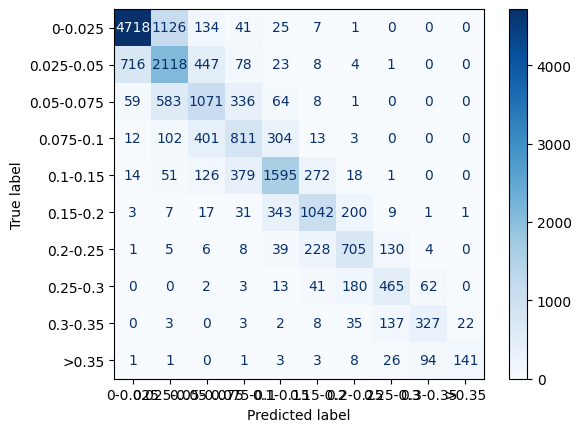

In [27]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from tqdm import tqdm
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt


results_list = []
for batch_idx, (X, y, gender, filename, color) in tqdm(enumerate(validation_generator), total=len(validation_generator)):
    X, y = X.to(device), y.to(device).view(-1, 1)
    
    y_preds = []
    for i in range(len(X)):  
        if color[i] == 1:  # 
            y_pred = model_color(X[i].unsqueeze(0))  
        else:
            y_pred = model_gray(X[i].unsqueeze(0)) 
        y_preds.append(y_pred.item())
    
    y_np = y.cpu().numpy().flatten()
    
    true_ranges = pd.cut(y_np, bins=bins, labels=labels, include_lowest=True)
    pred_ranges = pd.cut(y_preds, bins=bins, labels=labels, include_lowest=True)
    
    for i in range(len(X)):
        results_list.append({
            'true_range': str(true_ranges[i]), 
            'pred_range': str(pred_ranges[i]),
            'pred': float(y_preds[i]),
            'target': float(y_np[i]),
            'gender': float(gender[i])
        })

results_df = pd.DataFrame(results_list)

y_true = results_df['true_range']
y_pred = results_df['pred_range']
cm = confusion_matrix(y_true, y_pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [28]:
print(f"Classification Report:\n")
print(classification_report(y_true, y_pred, labels=labels, target_names=labels))

Classification Report:

              precision    recall  f1-score   support

     0-0.025       0.85      0.75      0.80      6288
  0.025-0.05       0.53      0.62      0.57      3396
  0.05-0.075       0.49      0.50      0.50      2122
   0.075-0.1       0.48      0.49      0.49      1646
    0.1-0.15       0.66      0.65      0.66      2456
    0.15-0.2       0.64      0.63      0.63      1654
    0.2-0.25       0.61      0.63      0.62      1126
    0.25-0.3       0.60      0.61      0.61       766
    0.3-0.35       0.67      0.61      0.64       537
       >0.35       0.86      0.51      0.64       278

   micro avg       0.65      0.64      0.64     20269
   macro avg       0.64      0.60      0.61     20269
weighted avg       0.66      0.64      0.65     20269



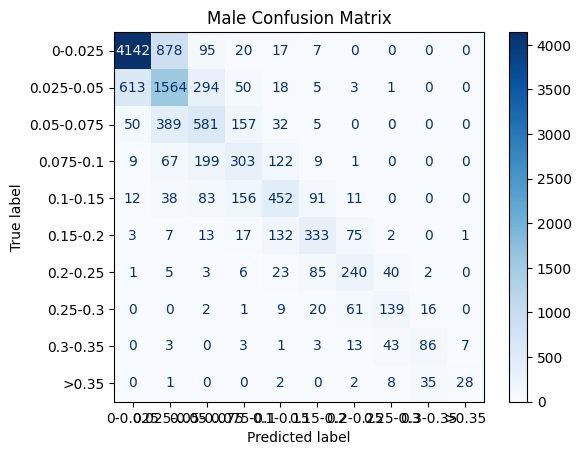

Classification Report for Male Confusion Matrix:

              precision    recall  f1-score   support

     0-0.025       0.86      0.77      0.81      5384
  0.025-0.05       0.53      0.61      0.57      2549
  0.05-0.075       0.46      0.48      0.47      1214
   0.075-0.1       0.42      0.43      0.43       710
    0.1-0.15       0.56      0.54      0.55       843
    0.15-0.2       0.60      0.57      0.58       583
    0.2-0.25       0.59      0.59      0.59       405
    0.25-0.3       0.60      0.56      0.58       248
    0.3-0.35       0.62      0.54      0.58       159
       >0.35       0.78      0.37      0.50        76

   micro avg       0.66      0.65      0.65     12171
   macro avg       0.60      0.55      0.57     12171
weighted avg       0.67      0.65      0.66     12171



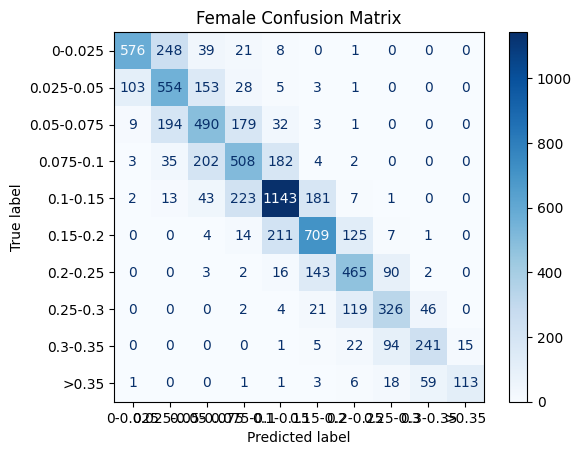

Classification Report for Female Confusion Matrix:

              precision    recall  f1-score   support

     0-0.025       0.83      0.64      0.72       904
  0.025-0.05       0.53      0.65      0.59       847
  0.05-0.075       0.52      0.54      0.53       908
   0.075-0.1       0.52      0.54      0.53       936
    0.1-0.15       0.71      0.71      0.71      1613
    0.15-0.2       0.66      0.66      0.66      1071
    0.2-0.25       0.62      0.64      0.63       721
    0.25-0.3       0.61      0.63      0.62       518
    0.3-0.35       0.69      0.64      0.66       378
       >0.35       0.88      0.56      0.68       202

   micro avg       0.63      0.63      0.63      8098
   macro avg       0.66      0.62      0.63      8098
weighted avg       0.64      0.63      0.64      8098

Male error:  0.0018175635119606392
Female error:  0.0012960507015616712


0.0020783199171601234

In [29]:
results_male = results_df.loc[results_df["gender"] == 1]
results_female = results_df.loc[results_df["gender"] == 0]
# print(results_male)
# print(results_female)

def plot_confusion_matrix(results, title):
    y_true = results['true_range']
    y_pred = results['pred_range']
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()
    
    print(f"Classification Report for {title}:\n")
    print(classification_report(y_true, y_pred, labels=labels, target_names=labels))


# Male Confusion Matrix
plot_confusion_matrix(results_male, "Male Confusion Matrix")

# Female Confusion Matrix
plot_confusion_matrix(results_female, "Female Confusion Matrix")

metric_fn(results_male, results_female)

#### Test

In [30]:
df_test = pd.read_csv("listes_training/data_100K/test_students.csv", delimiter=' ')
df_test = df_test.dropna()

def is_grayscale(image_path):
    img = Image.open(image_path).convert('RGB')
    img_np = np.array(img)
    if np.array_equal(img_np[..., 0], img_np[..., 1]) and np.array_equal(img_np[..., 0], img_np[..., 2]):
        return True
    return False

df_test['is_grayscale'] = df_test['filename'].apply(lambda x: is_grayscale(f"{image_dir}/{x}"))
df_test.head()


,filename,is_grayscale
0,database2/database2/test/0.jpg,False
1,database2/database2/test/1.jpg,False
2,database2/database2/test/2.jpg,True
3,database2/database2/test/3.jpg,False
4,database2/database2/test/4.jpg,False


In [31]:
class Dataset_test(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
         'Initialization'
         self.image_dir = image_dir
         self.df = df
         self.transform = transforms.ToTensor()
         
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.df.loc[index]
        filename = row['filename']
        is_gray = row['is_grayscale']
        # Load data and get label
        img = Image.open(f"{image_dir}/{filename}")

        X = self.transform(img)

        return X, is_gray, filename

test_set = Dataset_test(df_test, image_dir)
params_test = {'batch_size': 8,
          'shuffle': False,
          'num_workers': 0}

test_loader = torch.utils.data.DataLoader(test_set, **params_test)


# Prediction
results_list = []
for batch_idx, (X, is_gray, filename) in tqdm(enumerate(test_loader), total=len(test_loader)):
    X = X.to(device)
    for i in range(len(X)):  
        if is_gray[i].item():  # Test if the image is grayscale image
            y_pred = model_gray(X[i].unsqueeze(0)) 
        else:
            y_pred = model_color(X[i].unsqueeze(0)) 
        
        results_list.append({'pred': float(y_pred.squeeze().item())})

test_df = pd.DataFrame(results_list)
test_df.head()

100%|██████████| 3814/3814 [02:03<00:00, 30.86it/s]


,pred
0,0.307591
1,0.355882
2,0.119028
3,0.309866
4,0.405662


In [32]:
test_df.to_csv("Data_Challenge.csv", header = None, index = None)